## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction



For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up



`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 
a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
#i used dummies here to make life easier 
df[['new','old']] = pd.get_dummies(df['landing_page'])

In [8]:
df[['control','tret']] = pd.get_dummies(df['group'])

In [9]:
df.head()

,user_id,timestamp,group,landing_page,converted,new,old,control,tret
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,0


In [10]:
#if the sum was equal to 1 then that means there is miss match

not_match = df[(df['new']+df['tret']) == 1].index

In [65]:
len(not_match)

3893

f. Do any of the rows have missing values?

In [11]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
new             0
old             0
control         0
tret            0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page, so we are going to drop it.

a. drop columns that group does not match type of page on **df2**.

In [12]:
df2 = df.drop(index = not_match)

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` finding duplicate users

a. How many unique **user_id**s are in **df2**?

In [14]:
df2.user_id.nunique()

290584

In [15]:
df2.shape[0]

290585

b. There is one **user_id** repeated in **df2**.  What is it?

In [16]:
df2[df2.user_id.duplicated()] 

,user_id,timestamp,group,landing_page,converted,new,old,control,tret
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,1,0,0,1


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
df2 =df2.drop(index = df2[df2.user_id.duplicated()].index)

In [66]:
#check if its removed
df2.shape[0]

290584

`4.` genral information about conversion

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
df2[df2['control'] == 1].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
df2[df2['tret'] == 1].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [22]:
df.new.mean()

0.5

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**using whats in (a) to (d) we can say ther number of conversions became less.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, then we can say

**H0 : $p_{new}$ - $p_{old}$ <= 0**<br>
**H1 : $p_{new}$ - $p_{old}$ > 0**



where $p_{new}$ stands for proportion of people converting using the new page, and $p_{old}$ stands for proportion of peaple conveting using old page 

`2.` we will Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

we will Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

we willPerform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



In [23]:
#make some helpful masks to make life easier
new = df2['new'] == 1 
old = df2['old'] == 1 

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [24]:
pnew = df2.converted.mean()
pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [25]:
pold = df2.converted.mean()
pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [26]:
df2[new].count()[0]

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [27]:
df2[old].count()[0]

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.normal(df2.converted.mean(),df2[new].converted.std(),df2[new].shape[0])


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.normal(df2.converted.mean(),df2[old].converted.std(),df2[old].shape[0])



g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
new_page_converted.mean() - old_page_converted.mean()


0.0025023089970706985

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [31]:
# it takes some time, so i printed done! to know if it ended
p_diffs = np.array([])
old_std = df2[old].converted.std()
new_std = df2[new].converted.std()
for i in range(10000):
    old_mean = np.random.normal(pold, old_std, df2[old].shape[0]).mean()
    new_mean = np.random.normal(pnew, new_std, df2[new].shape[0]).mean()
    p_diffs = np.append(p_diffs,[new_mean - old_mean])
print('done!')

done!


i. Plot a histogram of the **p_diffs**

In [32]:
# obs_diff stands for " observed differance " in the data provided
obs_diff = df2[new].converted.mean() - df2[old].converted.mean()
obs_diff

-0.0015782389853555567

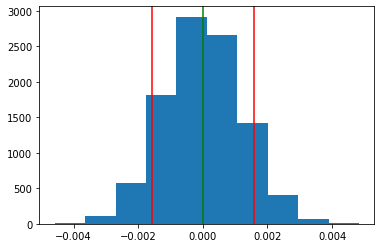

In [33]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color = 'r' )
plt.axvline(x=p_diffs.mean(), color = 'g' )
plt.axvline(x=(p_diffs.mean() - obs_diff + p_diffs.mean()), color = 'r' );

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
(p_diffs > obs_diff).mean()

0.9063

### what we calculated in part **j** is called p-value. since p-value is bigger than our type 1 error threshold  = 0.05, we failed to reject the null

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.  the below variables are used to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
import statsmodels.api as sm

convert_old = df2[old][df['converted'] == 1].shape[0]
convert_new = df2[new][df['converted'] == 1].shape[0]
n_old = df2[old].shape[0]
n_new = df2[new].shape[0]

C:\Users\alhaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alhaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


m. Now we will use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [67]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new], value = 0)

In [38]:
z_score

1.3109241984234394

In [68]:
p_value

0.18988337448195103

**z-score shows how far by standared diviation is the point from the mean, p-value means the probability of chosing the altenitive hypotheses when the null is actully True<br><br>**


***here the result of p value dont agree with the result above (part j), because the null and alturnitive hypotheses are diffrant. ***<br>

using bulit in method its <br><br>

H0 : $p_{new}$ - $p_{old}$ = 0<br>
H1 : $p_{new}$ - $p_{old}$ != 0
<br><br>
if we want to calculate it the same way then we can use what is below:

In [69]:
# we can see here its the same id p_value variable
(p_diffs < obs_diff).mean()+(p_diffs > (p_diffs.mean() - obs_diff + p_diffs.mean())).mean()

0.1892

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, we will use **logistic regression, witch is used with categorical variables.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [41]:
df2['intercept'] = 1

In [42]:
df2.head()

,user_id,timestamp,group,landing_page,converted,new,old,control,tret,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,0,1


In [43]:
df2 =df2.drop(columns = ['control','old','new'])

In [44]:
df2.rename(columns = {'tret' : 'ab_page'}, inplace = True)

In [45]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to instantiate our regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [46]:
data = sm.Logit(df2['converted'], df2[['intercept','ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below.

In [47]:
data.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 04 Oct 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:54:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

in previuos it p-value was 0.9065 
<br>
 


with a hypothysis: <br><br>. H0 : $p_{new}$ - $p_{old}$ <= 0<br>
H1 : $p_{new}$ - $p_{old}$ > 0 <br><br>

now p-value is 0.190 witch is the same as as (m) in (part II) <br>
with hypotheses:  
H0 : $p_{new}$ - $p_{old}$ = 0<br>
H1 : $p_{new}$ - $p_{old}$ != 0


**since ab_page isn't statisticly signeficent we need to use another factor.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.

Does it appear that country had an impact on conversion? 

In [48]:
df_c = pd.read_csv('countries.csv')

In [49]:
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [50]:
df_c['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [51]:
df2 = df2.merge(df_c, on = 'user_id')

In [52]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [53]:
df2[['ca','uk','us']] = pd.get_dummies(df2['country'])

In [54]:
df2 = df2.drop(columns = 'us')

In [55]:
data = sm.Logit(df2['converted'], df2[['intercept','ab_page','ca','uk']]).fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [56]:
data.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 04 Oct 2019   Pseudo R-squ.:               2.323e-05
Time:                        18:54:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
ca            -0.0408      0.027     -1.516      0.130      -0.093       0.012
uk             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

## summary <br>

it appered that the country isn't statistically significant since p-value of ca and uk is bigger than 0.05 the threshold of type 1 error 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [57]:
df2['ca_tret'] = df2['ab_page']*df2['ca']

In [58]:
df2['uk_tert'] = df2['ab_page']*df2['uk']

In [59]:
 df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,ca,uk,ca_tret,uk_tert
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,0,0


In [60]:
data = sm.Logit(df2['converted'], df2[['intercept','ab_page','ca','uk','ca_tret','uk_tert']]).fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [61]:
data.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 04 Oct 2019   Pseudo R-squ.:               3.482e-05
Time:                        18:54:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
ca            -0.0175      0.038     -0.465      0.642      -0.091       0.056
uk            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ca_tret       -0.0469      0.054     -0.872      0.383      -0.152       0.059
uk_tert        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

## summary <br>
based in result non of these factors are statistically significant, since p-value for every factor is higher than 0.05 the threshold of tye 1 error


# conclusion
<br> finnaly since non of these factors appered stastically significant we think the experimant should take more time to give clearer result in witch we should keep the old page or change it to the new one (time calculations are down)  

In [62]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

In [63]:
#the experment runned only for 21 days
(df2.timestamp.max() - df2.timestamp.min()).days

21

In [71]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0